# Besian Neural Network

In [46]:
import pandas as pd  
import torch  
import torch.nn as nn  
import torch.nn.functional as F  
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
import numpy as np

# 1. 数据准备  
class MyDataset(Dataset):  
    def __init__(self, X, y):  
        self.X = X  
        self.y = y  

    def __len__(self):  
        return len(self.y)  

    def __getitem__(self, idx):  
        return self.X[idx], self.y[idx]  

/home/ackerman/Public/miniconda3/envs/pcdet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ackerman/Public/miniconda3/envs/pcdet/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


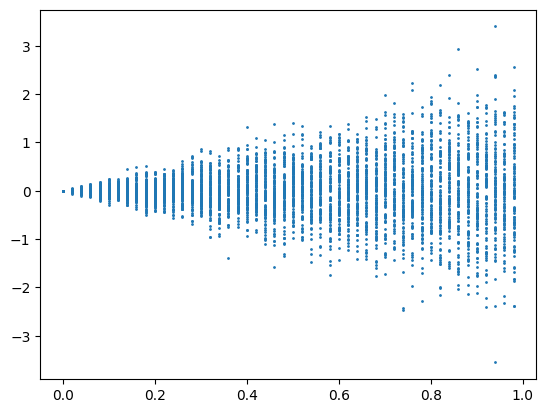

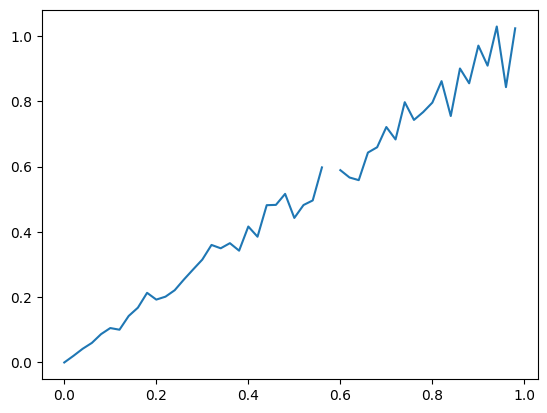

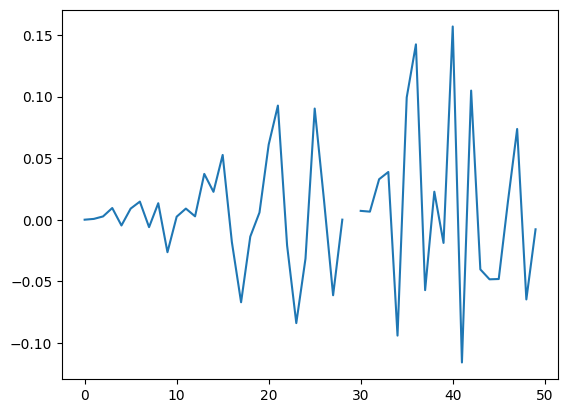

In [62]:
# 制作数据集
X = np.arange(0, 1, 0.02).repeat(100)
y = np.array([np.random.normal(0, X[i]) for i in range(len(X))])
stdList = X

grid = [[] for i in range(len(np.arange(0, 1, 0.02)))]
std_grid = []
for i in range(len(X)):
    grid[int(X[i]*50)].append(y[i])

for i in range(len(grid)):
    std_grid.append(np.std(grid[i]))

import matplotlib.pyplot as plt
plt.plot(X, y, 'o', markersize=1)
plt.figure()
plt.plot(np.arange(0, 1, 0.02), std_grid)
plt.figure()
plt.plot([np.mean(grid[i]) for i in range(len(grid))])


In [48]:
# 转为 PyTorch tensors  
X_tensor = torch.FloatTensor(X)  
y_tensor = torch.FloatTensor(y)

# 创建数据加载器  
dataset = MyDataset(X_tensor, y_tensor)  
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  

# 2. 定义贝叶斯神经网络  
class BayesianNN(nn.Module):  
    def __init__(self):  
        super(BayesianNN, self).__init__()  
        self.fc1 = nn.Linear(1, 64)  
        self.dropout = nn.Dropout(0.5)  # 设置Dropout比例
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.predict = nn.Linear(64, 1)  # 输出层
        self.get_log_var = nn.Linear(64, 1)  # 输出层

    def forward(self, x):  
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)  # Dropout层

        y = self.predict(x)  # 输出层
        log_var = self.get_log_var(x)

        return y, log_var # 返回预测值和log(方差)

# 3. 定义损失函数
def loss_fn(y, y_pred, log_var):
    return torch.sum(0.5 * torch.exp(-log_var) * (y - y_pred) ** 2 + 0.5 * log_var)

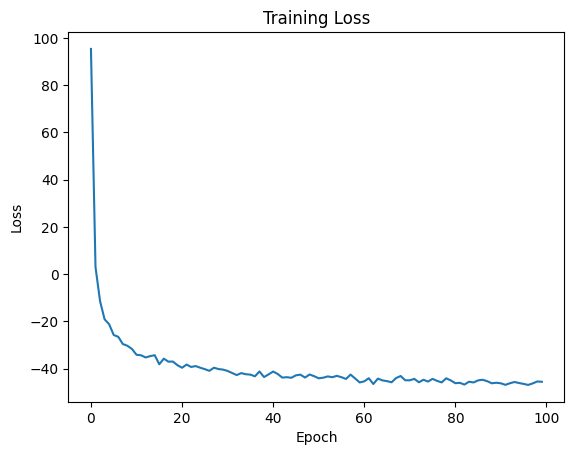

Epoch [100/100], Loss: -45.5347


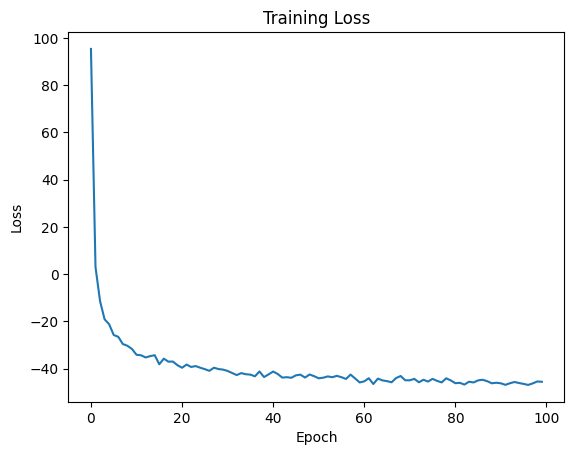

In [49]:
from IPython.display import clear_output, display
 
import torch.nn as nn
import torch.optim as optim

# 3. 训练模型  
model = BayesianNN()  
criterion = loss_fn
optimizer = optim.Adam(model.parameters(), lr=0.0001)  

num_epochs = 100

losses = []

plt.ion()
fig, ax = plt.subplots()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs = inputs.view(-1, 1)  # Reshape inputs to match the model's expected input shape
        outputs = model(inputs)
        loss = criterion(targets, outputs[0], outputs[1])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    clear_output(wait=True)
    ax.clear()
    ax.plot(losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    display(fig)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')


In [63]:
# 4. 使用 MC Dropout 进行预测  
def predict_with_uncertainty(model, x, n_iter=100, dimy=2):  
    model.train()  # 确保模型处于训练模式以启用Dropout  
    predictions = []
    log_var = []
    
    for i in range(n_iter):  
        with torch.no_grad():  
            mean_pred, log_var_pred = model(x)
            predictions.append(mean_pred.cpu().numpy())
            log_var.append(log_var_pred.cpu().numpy())
    
    predictions = np.array(predictions)
    log_var = np.array(log_var)
    pred_mean = np.mean(predictions, axis=0) 
    uncertainty_epistemic = np.sqrt(np.var(predictions, axis=0))
    uncertainty_aleatoric = np.sqrt(np.mean(np.exp(log_var), axis=0))
    return pred_mean, uncertainty_epistemic, uncertainty_aleatoric

# 进行预测
y_pred = []
y_uncertainty = []
for i in range(len(X_tensor)):
    model.eval()  
    mean_y, u_e, u_a = predict_with_uncertainty(model, X_tensor[i].view(1, -1), dimy=1)
    y_pred = np.append(y_pred, mean_y)
    y_uncertainty = np.append(y_uncertainty, np.sqrt(u_e**2 + u_a**2))
    if i % 100 == 0:
        print(f'Prediction {i}/{len(X_tensor)}')


Prediction 0/5000
Prediction 100/5000
Prediction 200/5000
Prediction 300/5000
Prediction 400/5000
Prediction 500/5000
Prediction 600/5000
Prediction 700/5000
Prediction 800/5000
Prediction 900/5000
Prediction 1000/5000
Prediction 1100/5000
Prediction 1200/5000
Prediction 1300/5000
Prediction 1400/5000
Prediction 1500/5000
Prediction 1600/5000
Prediction 1700/5000
Prediction 1800/5000
Prediction 1900/5000
Prediction 2000/5000
Prediction 2100/5000
Prediction 2200/5000
Prediction 2300/5000
Prediction 2400/5000
Prediction 2500/5000
Prediction 2600/5000
Prediction 2700/5000
Prediction 2800/5000
Prediction 2900/5000
Prediction 3000/5000
Prediction 3100/5000
Prediction 3200/5000
Prediction 3300/5000
Prediction 3400/5000
Prediction 3500/5000
Prediction 3600/5000
Prediction 3700/5000
Prediction 3800/5000
Prediction 3900/5000
Prediction 4000/5000
Prediction 4100/5000
Prediction 4200/5000
Prediction 4300/5000
Prediction 4400/5000
Prediction 4500/5000
Prediction 4600/5000
Prediction 4700/5000
Pred

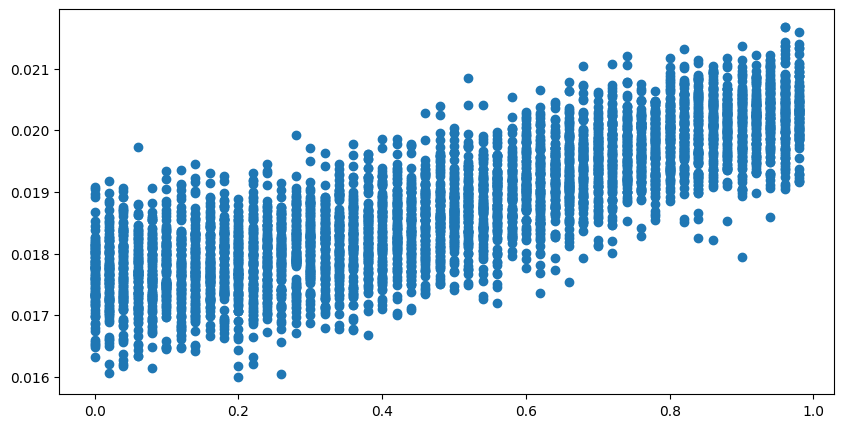

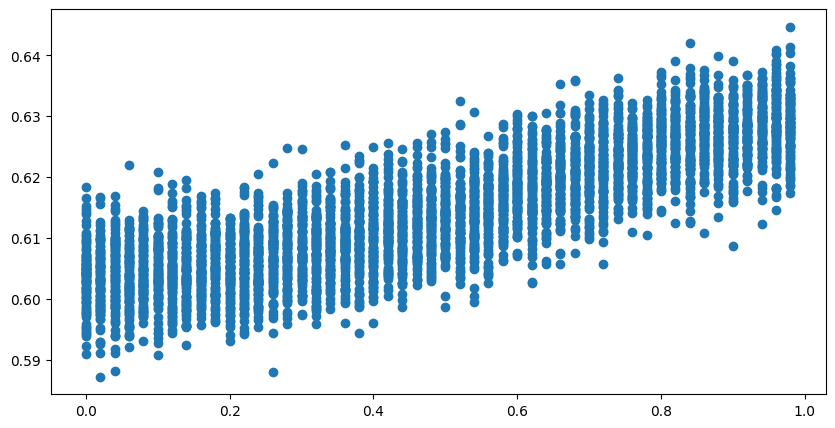

In [64]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y_pred)
plt.figure(figsize=(10, 5))
plt.scatter(X, y_uncertainty)



Text(0, 0.5, 'uncertainty')

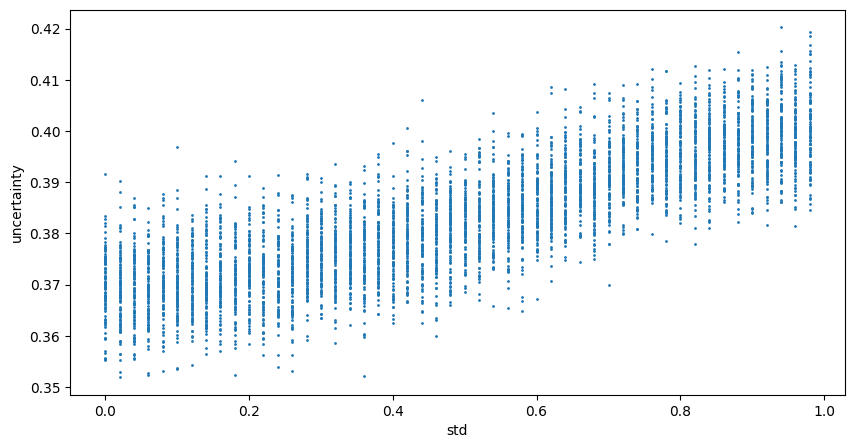

In [55]:
plt.figure(figsize=(10, 5))
plt.scatter(stdList, y_uncertainty, s=1)
plt.xlabel('std')
plt.ylabel('uncertainty')